In [14]:
import cv2
import os
import numpy as np

directory_path = 'MCI/video_sequence'
frame_list = []

width = height = 128

for filename in os.listdir(directory_path):
    if filename.endswith(".avi"):
        video_path = os.path.join(directory_path, filename)
        cap = cv2.VideoCapture(video_path)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to grayscale
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Resize the frame
            resized_frame = cv2.resize(gray_frame, (width, height))

            # Add the frame to the list
            frame_list.append(resized_frame)

        cap.release()

cv2.destroyAllWindows()

# Checking the shape of the first frame in the list
print(len(frame_list))
print(frame_list[0].shape)  # Should output: (32, 32)

25200
(128, 128)


In [15]:
# Convert list to NumPy array and add an extra dimension
X_train = np.array(frame_list, dtype=np.float32)[..., np.newaxis]

# Normalize the data to the range [0, 1]
X_train = X_train / 255.0

print(X_train.shape)  # Should output: (num_frames, 32, 32, 1)


(25200, 128, 128, 1)


In [16]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, LeakyReLU, BatchNormalization, Reshape, Flatten, Dense
from tensorflow.keras.models import Model

def build_autoencoder(input_shape):
    # Encoder
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=2, padding='same')(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    # Flatten and bottleneck
    volume_size = x.shape
    x = Flatten()(x)
    latent = Dense(100)(x)  # Latent vector

    # Decoder
    x = Dense(np.prod(volume_size[1:]))(latent)
    x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    output_layer = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, output_layer)
    return autoencoder

In [17]:
autoencoder = build_autoencoder(X_train.shape[1:])
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32)


Epoch 1/50
788/788 [==============================] - 202s 255ms/step - loss: 0.0062
Epoch 2/50
788/788 [==============================] - 194s 246ms/step - loss: 0.0040
Epoch 3/50
788/788 [==============================] - 196s 248ms/step - loss: 0.0037
Epoch 4/50
788/788 [==============================] - 282s 358ms/step - loss: 0.0035
Epoch 5/50
788/788 [==============================] - 493s 626ms/step - loss: 0.0034
Epoch 6/50
788/788 [==============================] - 376s 476ms/step - loss: 0.0033
Epoch 7/50
788/788 [==============================] - 211s 268ms/step - loss: 0.0032
Epoch 8/50
788/788 [==============================] - 157s 199ms/step - loss: 0.0031
Epoch 9/50
788/788 [==============================] - 161s 204ms/step - loss: 0.0031
Epoch 10/50
788/788 [==============================] - 158s 201ms/step - loss: 0.0030
Epoch 11/50
788/788 [==============================] - 163s 207ms/step - loss: 0.0030
Epoch 12/50
788/788 [==============================] - 162s 205

In [18]:
decoded_frames = autoencoder.predict(X_train)
decoded_frames[0]

788/788 [==============================] - 53s 67ms/step


array([[[0.3124812 , 0.31260705, 0.3125659 ],
        [0.29696283, 0.29670897, 0.29642186],
        [0.28836015, 0.28825578, 0.28828672],
        ...,
        [0.18505482, 0.18422222, 0.18404385],
        [0.03113667, 0.03111639, 0.03120033],
        [0.01733206, 0.01732087, 0.01736838]],

       [[0.29720902, 0.29727957, 0.29731882],
        [0.29725787, 0.29696447, 0.2969375 ],
        [0.2901945 , 0.2900471 , 0.29038796],
        ...,
        [0.15809752, 0.15764263, 0.15818255],
        [0.02192572, 0.0219703 , 0.02214774],
        [0.00663956, 0.00664839, 0.00667809]],

       [[0.31240126, 0.31234285, 0.3123976 ],
        [0.31725824, 0.31740057, 0.31745222],
        [0.30147895, 0.30159974, 0.30154237],
        ...,
        [0.14204542, 0.14242998, 0.1429463 ],
        [0.03102745, 0.03117166, 0.0313081 ],
        [0.01254548, 0.01258845, 0.01259073]],

       ...,

       [[0.310113  , 0.31013265, 0.31017902],
        [0.31257302, 0.31253776, 0.3126865 ],
        [0.28497583, 0

In [19]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def show_frame(frame_index):
    frame = decoded_frames[frame_index]

    # Rescale if the frames are normalized
    if frame.max() <= 1.0:
        frame = frame * 255.0

    # Use 'gray' color map if the images are grayscale
    plt.imshow(frame.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.show()


# Create a slider to browse through the frames
frame_slider = widgets.IntSlider(value=0, min=0, max=len(decoded_frames)-1, step=1, description='Frame:')

# Display the widget
widgets.interactive(show_frame, frame_index=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame:', max=25199), Output()), _dom_classes=('widget-in…

RuntimeError: Requested MovieWriter (ffmpeg) not available

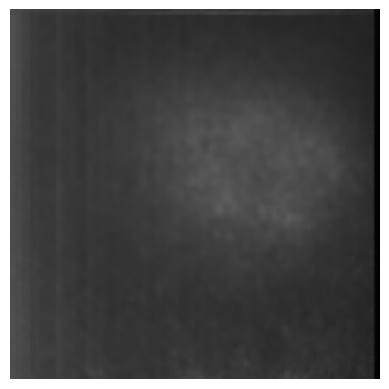

In [21]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

def update_frame(frame_index, decoded_frames, ax):
    ax.clear()
    frame = decoded_frames[frame_index]

    # Rescale if the frames are normalized
    if frame.max() <= 1.0:
        frame *= 255.0

    # Use 'gray' color map if the images are grayscale
    ax.imshow(frame.astype('uint8'), cmap='gray')
    ax.axis('off')

def show_sequence(decoded_frames, save_path):
    fig, ax = plt.subplots()
    ani = FuncAnimation(fig, update_frame, frames=len(decoded_frames), fargs=(decoded_frames, ax), interval=100)

    # Set up writer
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

    # Save to file
    ani.save(save_path, writer=writer)

# Example usage
save_path = 'animation.mp4'  # Specify your save path here
show_sequence(decoded_frames, save_path)


In [23]:
import cv2

for frame in decoded_frames:
    # Convert frame to BGR if it's in grayscale or another format
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    # Display the frame
    cv2.imshow('Frame', frame)

    # Wait for 25 ms and break the loop with a keyboard interrupt
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Close the window
cv2.destroyAllWindows()


2023-11-11 21:30:53.956 Python[71416:3184902] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
